<center><i>Łukasz Staniszewski</i></center>
<h1><center>Football frames classifier</center></h1>
<h3><center>ReSpo-Vision recruitment task</center></h3> 

# I. Task
Aim of the task is to create a model, which will differentiate between different types of views encountered during a football match. We would like to be able to select only those frames, which contain valuable information to be processed by our data extraction system.

The task is stated as a multiclass classification problem.

# II. Solution

## IMPORT, SEED, CUDA
+ Import:

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as Functional
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import os
import PIL
import pandas as pd

+ GPU:

In [2]:
torch.cuda.set_device(0)
device = torch.device("cuda")
torch.cuda.is_available()

True

+ Seeds:

In [3]:
if torch.cuda.is_available():
    torch.cuda.manual_seed(500)
    torch.cuda.manual_seed_all(500)

torch.manual_seed(500)

torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False


## Data
+ Datasets + data augmentation:

In [4]:
class ImagesDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = None):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform
        self.class2index = {"side_view":0, "closeup":1, "non_match": 2, "front_view":3, "side_gate_view":4, "aerial_view":5, "wide_view":6}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        filename = self.df["basename"][index]
        label = self.class2index[self.df["category"][index]]
        image = PIL.Image.open(os.path.join(self.images_folder, filename))
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [5]:
transform_orig = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(size=(360,640))]
)

transform_aug = transforms.Compose(
    [transforms.RandomRotation(25),
     transforms.ToTensor(),
     transforms.Resize(size=(540,960)),
     transforms.RandomErasing(0.5),
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

In [6]:
dataset_no_aug = ImagesDataset(csv_path="../data/df_train_framefilter.csv", images_folder="../data/raw/train",transform=transform_orig)
# dataset_no_aug = ImagesDataset(csv_path="../data/df_train_framefilter.csv", images_folder="../data/raw/train",transform=transform_aug)
# dataset_aug = torchvision.datasets.ImageFolder("data/train/", transform=transform_aug)
# dataset = torch.utils.data.ConcatDataset([dataset_no_aug, dataset_aug])

In [7]:
img = dataset_no_aug[0][0]

In [8]:
img[2].shape

torch.Size([360, 640])

In [9]:
# means = [[],[],[]]
# stds = [[],[],[]]
# it = 0
# for img, _ in dataset_no_aug:
#     means[0].append(torch.mean(img[0]))
#     means[1].append(torch.mean(img[1]))
#     means[2].append(torch.mean(img[2]))
#     stds[0].append(torch.std(img[0]))
#     stds[1].append(torch.std(img[1]))
#     stds[2].append(torch.std(img[2]))
#     it += 1
#     if it % 1000 == 0:
#         print(it)
# print(means)
# print(stds)

+ Rozdzielenie między trenującym a walidacyjnym:

In [10]:
VALIDATION_SET_RATIO = 0.2
dataset_indices = list(range(len(dataset_no_aug)))
np.random.shuffle(dataset_indices)
valid_split_index = int(np.floor(VALIDATION_SET_RATIO * len(dataset_no_aug)))

train_idx, val_idx = dataset_indices[valid_split_index:], dataset_indices[:valid_split_index]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(val_idx)

+ Data loading:

In [11]:
BATCH_SIZE = 16
# no shuffle - using it in sampler
train_loader = torch.utils.data.DataLoader(dataset_no_aug, batch_size=BATCH_SIZE, shuffle=False, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset_no_aug, batch_size=BATCH_SIZE, shuffle=False, sampler=valid_sampler)

+ Przykładowe obrazki:

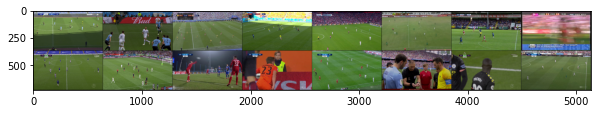

In [12]:
plt.figure(figsize=(10, 20))


def imshow(img):
    # img = img / 2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

+ Klasy:

In [13]:
dataset_no_aug.class2index

{'side_view': 0,
 'closeup': 1,
 'non_match': 2,
 'front_view': 3,
 'side_gate_view': 4,
 'aerial_view': 5,
 'wide_view': 6}

## Konwolucyjna sieć neuronowa
+ Zdefiniowanie podstawowych elementów.

In [14]:
next(iter(train_loader))[0].shape

torch.Size([16, 3, 360, 640])

In [15]:
class FramesNet(nn.Module):
    def __init__(self):
        super().__init__()
        # we: 64x64
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=(5,5))
        self.bn1 = nn.BatchNorm2d(10)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=(2, 2))
        # self.drop1 = nn.Dropout(0.5)

        #
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=25, kernel_size=(5,5))
        self.bn2 = nn.BatchNorm2d(25)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        #
        self.conv3 = nn.Conv2d(in_channels=25, out_channels=50, kernel_size=(5,5))
        self.bn3 = nn.BatchNorm2d(50)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.drop2 = nn.Dropout(0.5)


        #
        self.conv4 = nn.Conv2d(in_channels=50, out_channels=60, kernel_size=(5,5))
        self.bn4 = nn.BatchNorm2d(60)
        #

        # 6 x 6

        self.fc1 = nn.Linear(5*5*100, 500)
        self.drop4 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(500, 50)
        self.drop5 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(50, 7)

    def forward(self, x):
        x=self.bn1(Functional.relu(self.conv1(x)))
        # x=self.drop1(x)
        x=self.bn2(Functional.relu(self.conv2(x)))
        x=self.pool1(x)


        x=self.bn3(Functional.relu(self.conv3(x)))
        # x=self.drop2(x)
        x=self.bn4(Functional.relu(self.conv4(x)))
        x=self.pool2(x)

        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = Functional.relu(self.fc1(x))
        x = self.drop4(x)
        x = Functional.relu(self.fc3(x))
        x = self.drop5(x)
        x = self.fc4(x)

        return x


net = FramesNet().to(device)
net

FramesNet(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 25, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(25, 50, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(50, 60, kernel_size=(5, 5), stride=(1, 1))
  (bn4): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2500, out_features=500, bias=True)
  (drop4): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_feat

In [16]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(net.parameters())

+ Uczenie:

In [17]:
def get_val_loss(model, val_loader, crit):
    running_loss = 0.0
    with torch.no_grad():
        model.eval()
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = crit(outputs, labels)
            running_loss += loss.item()
        model.train()
    return running_loss / len(val_loader)

In [18]:
N_EPOCHS = 40
for epoch in range(N_EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    val_loss = get_val_loss(model=net, val_loader=valid_loader, crit=criterion)
    print("[{}/{}] training loss: {} | valid loss: {}".format(epoch+1, N_EPOCHS, running_loss / len(train_loader), val_loss))
    running_loss = 0.0

print('Finished Training')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x776160 and 2500x500)

+ Wyniki:

In [28]:
def get_results_accuracy(loader, b_size):
    correct = 0
    total = 0
    all_outs = []
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device)
            outputs = net(images).cpu()
            _, predicted = torch.max(outputs.data, 1)
            all_outs.extend(predicted.tolist())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print('Accuracy of the network on the {} test images: {}'.format(len(loader)*b_size, acc))
    return acc, all_outs

+ Accuracy na treningowym i walidacyjnym:

In [29]:
acc_training, all_outs_training = get_results_accuracy(train_loader, BATCH_SIZE)
acc_valid, all_outs_valid = get_results_accuracy(valid_loader, BATCH_SIZE)

Accuracy of the network on the 140928 test images: 90.22923205840162
Accuracy of the network on the 35328 test images: 69.36143620043177


In [30]:
all_class_names = dataset_no_aug.classes
correct_predicts_by_class = {name_class: 0 for name_class in all_class_names}
predicts_by_class = {name_class: 0 for name_class in all_class_names}

with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        images = images.to(device)
        outputs = net(images).cpu()
        _, predicted = torch.max(outputs, 1)

        for label, model_prediction in zip(labels, predicted):
            if label == model_prediction:
                correct_predicts_by_class[all_class_names[label]] += 1
            predicts_by_class[all_class_names[label]] += 1


# print accuracy for each class
for name_class, count_ok in correct_predicts_by_class.items():
    acc = 100 * count_ok / predicts_by_class[name_class]
    print("Accuracy for {} = {:.2f}%".format(name_class, acc))

Accuracy for acoustic = 52.89%
Accuracy for antenna = 63.48%
Accuracy for bacteria = 73.04%
Accuracy for battery = 64.11%
Accuracy for bean = 73.78%
Accuracy for beetle = 76.80%
Accuracy for bicycle = 72.43%
Accuracy for birch = 65.05%
Accuracy for bird = 56.40%
Accuracy for bomb = 70.98%
Accuracy for bread = 61.92%
Accuracy for bridge = 79.03%
Accuracy for camera = 76.44%
Accuracy for carbon = 50.74%
Accuracy for cat = 62.43%
Accuracy for corn = 65.03%
Accuracy for crab = 57.95%
Accuracy for crocodilian = 64.76%
Accuracy for echinoderm = 61.41%
Accuracy for egg = 66.94%
Accuracy for elephant = 71.49%
Accuracy for fish = 68.49%
Accuracy for flower = 88.56%
Accuracy for frog = 57.51%
Accuracy for fungus = 71.16%
Accuracy for gauge = 62.24%
Accuracy for hammer = 85.23%
Accuracy for icecream = 65.87%
Accuracy for kangaroo = 65.97%
Accuracy for memorial = 80.50%
Accuracy for monkey = 75.28%
Accuracy for motor = 65.75%
Accuracy for nest = 55.75%
Accuracy for palm = 82.30%
Accuracy for pizza

+ Średnie accuracy na wszystkich klasach:

In [ ]:
sum_percents = 0
for name_class, count_ok in correct_predicts_by_class.items():
    sum_percents += 100 * count_ok / predicts_by_class[name_class]
print("FINAL CLASS AVERAGE: {:.2f}".format(sum_percents/50))

FINAL CLASS AVERAGE: 68.05


+ Predykowane klasy na walidacyjnym w postaci histogramu:

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

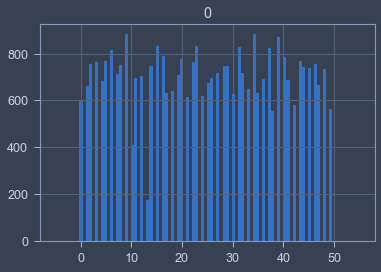

In [ ]:
import pandas as pd
pd.DataFrame(all_outs_valid).hist(bins=100, range=(-5,55))

## ZAPISANIE MODELU DO PLIKU I WCZYTANIE


+ Zapisanie:

In [19]:
state_dict = net.state_dict()

In [20]:
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%Y_%m_%d_%H_%M_%S")

file_name = f"model_{int(acc_valid)}acc_{dt_string}.tar"
torch.save(state_dict, file_name)


+ Wczytanie:

In [27]:
def load_model(model_name):
    state_dict = torch.load(model_name)
    net = ImageNet()
    net.load_state_dict(state_dict)
    net.to(device)
    return net

load_model("model_68acc_2021_12_01_22_47_19.tar")

ImageNet(
  (conv1): Conv2d(3, 80, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(80, 100, kernel_size=(2, 2), stride=(1, 1))
  (bn2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(100, 120, kernel_size=(1, 1), stride=(1, 1))
  (bn3): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(120, 140, kernel_size=(2, 2), stride=(1, 1))
  (bn4): BatchNorm2d(140, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(140, 200, kernel_size=(3, 3), stride=(1, 1))
  (bn5): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine

## ZAPISANIE WYNIKÓW DLA ZBIORU TESTOWEGO

In [22]:
eval_dataset = torchvision.datasets.ImageFolder("data/test/", transform=transform_orig)

In [23]:
preds_list_eval = []
net.eval()
with torch.no_grad():
    for index_x, x in enumerate(eval_dataset):
        x = x[0].to(device).unsqueeze(0)
        predicted_val = net(x).cpu()
        _, predicted = torch.max(predicted_val.data, 1)
        ret = (eval_dataset.imgs[index_x][0].lstrip(r"data/test/test_all\\"), predicted.item())
        preds_list_eval.append(ret)

df_out = pd.DataFrame(preds_list_eval)
df_out

,0,1
0,00013066837824360356.JPEG,26
1,00022240850406751722.JPEG,31
2,0004927347689911432.JPEG,2
3,000563265767796084.JPEG,39
4,0006013938786831874.JPEG,45
...,...,...
9995,9996231273861222.JPEG,12
9996,9996908958438282.JPEG,25
9997,9997674427283424.JPEG,31
9998,9997698258014044.JPEG,8


In [24]:
csv = df_out.to_csv(index=False, header=False)
with open('result.csv', 'w', newline="") as f:
    f.write(csv)

+ Przykładowe predykcje:

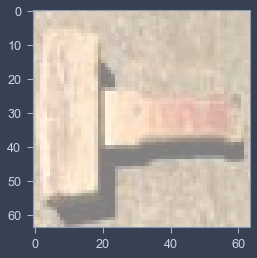

hammer


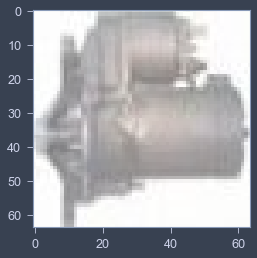

motor


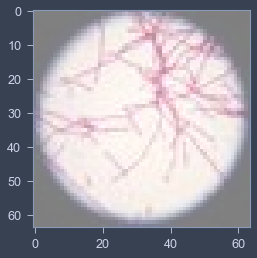

bacteria


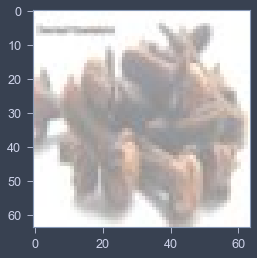

spice


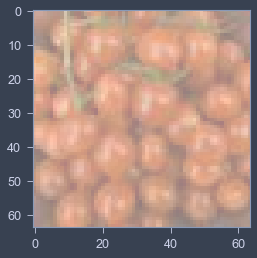

tomato


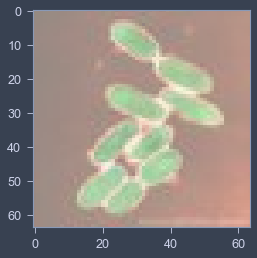

bacteria


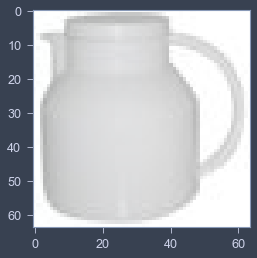

antenna


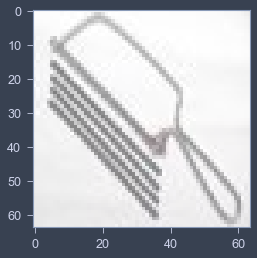

saw


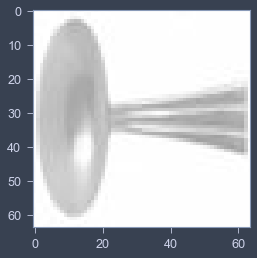

spoon


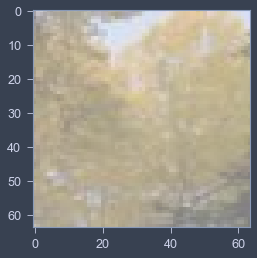

birch


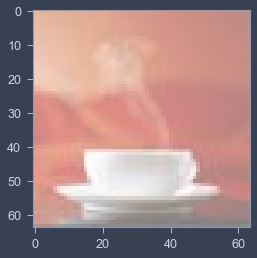

tea


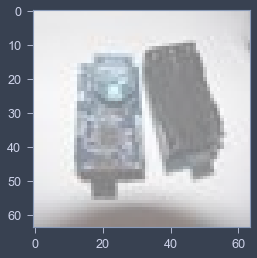

camera


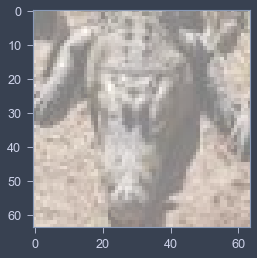

swine


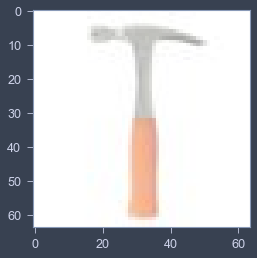

hammer


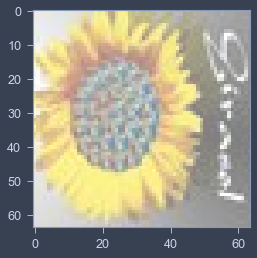

flower


In [25]:
for i in range(15):
    imshow(eval_dataset[i][0])
    print(all_class_names[preds_list_eval[i][1]])